# Perceptron
**Author:** Magdalena Whelley

**Topic:** Supervised Learning - Linear Classification with the Perceptron

## 1. Overview
The **Perceptron** is one of the earliest supervised learning algorithms for binary classification. It learns a linear decision boundary that separates two classes by iteratively updating its weights whenever a misclassification occurs.

In this notebook, we apply the perceptron to classify financial market sectors — distinguishing between the Technology (XLK) and Energy (XLE) ETFs — based on short-term return patterns and volatility.

This notebook will: 
- Load and preprocess ETF sector data.
- Create return, moving average, and volatility features.
- Implement the perceptron learning rule from scratch.
- Visualize convergence and classification performance.
- Discuss model interpretation and limitations.

In [1]:
# 2. Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf, os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Why the Perceptron?

The perceptron is a **linear classifier** that seeks a separating hyperplane between two classes.  
For each training example $(x_i, y_i)$, where $y_i \in \{0, 1\}$, the algorithm updates its parameters according to:

$$
w \leftarrow w + \eta (y_i - \hat{y_i}) x_i, \quad
b \leftarrow b + \eta (y_i - \hat{y_i})
$$

where:

- $w$ is the weight vector,  
- $b$ is the bias term, and  
- $\eta$ is the learning rate.  

When a prediction is correct, no update occurs; when a misclassification happens, the algorithm adjusts the decision boundary toward the correct class.

In [21]:
# 3. Load Sector ETF Data
import os, yfinance as yf, pandas as pd

csv_path = "sector_perceptron.csv"
tickers = ["XLK", "XLE"]  # Technology and Energy sector ETFs

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
else:
    data = yf.download(tickers, start="2020-01-01", end="2024-12-31")
    
    # Save directly in this directory
    df.to_csv(csv_path)
    print(f"✅ Downloaded and saved data to {csv_path}")

print("Columns after flattening:", list(df.columns))
display(df.head())


Columns after flattening: ['XLE', 'XLK']


,XLE,XLK
Date,,
2020-01-02,47.418163,88.833061
2020-01-03,47.277279,87.834282
2020-01-06,47.645161,88.043556
2020-01-07,47.519920,88.005478
2020-01-08,46.737190,88.947189


## 4. Feature Engineering

We compute three key indicators for each ETF:

- **Daily Return:** fractional daily price change.  
- **5-Day Moving Average:** short-term trend.  
- **5-Day Volatility:** recent standard deviation of returns.  

We then define the binary target variable:  
**1 → Tech (XLK) outperforming Energy (XLE)**  
**0 → Energy outperforming Tech (XLE)**

In [22]:
returns = df.pct_change()
rolling_mean = returns.rolling(5).mean()
rolling_vol = returns.rolling(5).std()

# Combine features
feat = pd.DataFrame({
    "Return_XLK": returns["XLK"],
    "Return_XLE": returns["XLE"],
    "MA_XLK": rolling_mean["XLK"],
    "MA_XLE": rolling_mean["XLE"],
    "Vol_XLK": rolling_vol["XLK"],
    "Vol_XLE": rolling_vol["XLE"]
})

# Label: 1 if Tech outperforming Energy
feat["Target"] = np.where(feat["Return_XLK"] > feat["Return_XLE"], 1, 0)
feat.dropna(inplace=True)

print("Feature sample:")
display(feat.head())

Feature sample:


,Return_XLK,Return_XLE,MA_XLK,MA_XLE,Vol_XLK,Vol_XLE,Target
Date,,,,,,,
2020-01-09,0.011336,0.007369,0.002549,-0.001384,0.009257,0.009904,1
2020-01-10,-0.002326,-0.005652,0.004332,-0.001920,0.006333,0.010082,1
2020-01-13,0.012507,0.000334,0.006357,-0.003410,0.007123,0.008753,1
2020-01-14,-0.004711,0.000167,0.005501,-0.002851,0.008302,0.008903,0
2020-01-15,0.001157,-0.007353,0.003592,-0.001027,0.007895,0.005813,1


In [23]:
# 5. Data Preparation
X = feat[["Return_XLK", "Return_XLE", "MA_XLK", "MA_XLE", "Vol_XLK", "Vol_XLE"]].values
y = feat["Target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Feature matrix:", X_train.shape)
print("Target distribution:", pd.Series(y_train).value_counts().to_dict())

Feature matrix: (939, 6)
Target distribution: {1: 475, 0: 464}


## 6. Implementing the Perceptron

The perceptron algorithm updates its parameters after each misclassified observation.  
This continues for a specified number of epochs until convergence.

In [24]:
class Perceptron:
    def __init__(self, lr=0.01, n_iter=25):
        self.lr = lr
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        self.errors = []

        for _ in range(self.n_iter):
            error_count = 0
            for xi, target in zip(X, y):
                linear = np.dot(xi, self.w) + self.b
                y_pred = 1 if linear >= 0 else 0
                update = self.lr * (target - y_pred)
                if update != 0:
                    self.w += update * xi
                    self.b += update
                    error_count += 1
            self.errors.append(error_count)
        return self

    def predict(self, X):
        linear = np.dot(X, self.w) + self.b
        return np.where(linear >= 0, 1, 0)


Weights: [ 0.40028425 -0.54543506  0.00388854 -0.00762437 -0.00361099 -0.00347315]
Bias: 3.469446951953614e-18


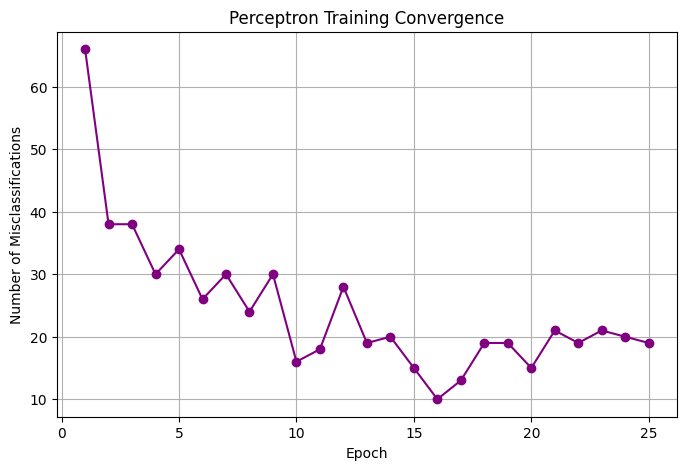

In [25]:
# 7. Trading and Convergence
model = Perceptron(lr=0.01, n_iter=25)
model.fit(X_train, y_train)

print("Weights:", model.w)
print("Bias:", model.b)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(model.errors)+1), model.errors, marker='o', color='purple')
plt.title("Perceptron Training Convergence")
plt.xlabel("Epoch")
plt.ylabel("Number of Misclassifications")
plt.grid(True)
plt.show()

In [26]:
# 8. Evaluation
y_pred = model.predict(X_test)

accuracy = np.mean(y_pred == y_test)
precision = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1)
recall = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Test Accuracy: 98.72%
Precision: 0.977
Recall: 1.000


## 9. Decision Boundary Visualization (2D Projection)

We visualize the model’s classification behavior on the 2D plane of **daily returns** (Return_XLK vs Return_XLE).

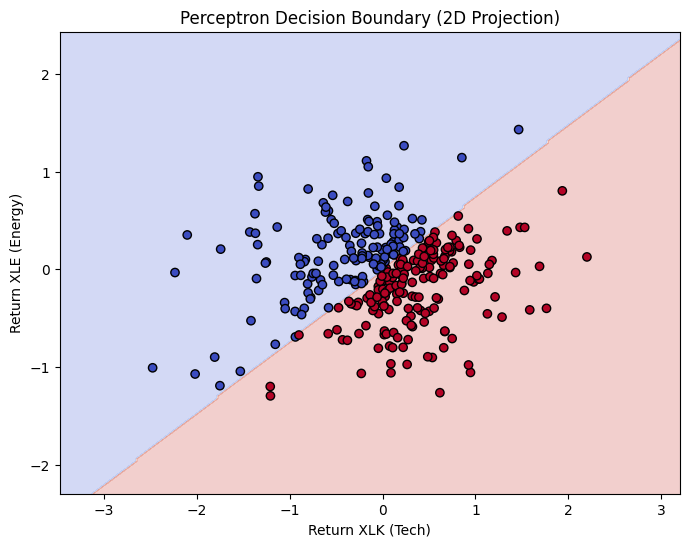

In [27]:
def plot_decision_boundary_2d(X, y, model):
    X_vis = X[:, :2]
    x_min, x_max = X_vis[:,0].min() - 1, X_vis[:,0].max() + 1
    y_min, y_max = X_vis[:,1].min() - 1, X_vis[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel(), np.zeros((xx.ravel().shape[0], 4))]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.25, cmap='coolwarm')
    plt.scatter(X_vis[:,0], X_vis[:,1], c=y, cmap='coolwarm', edgecolors='k')
    plt.xlabel("Return XLK (Tech)")
    plt.ylabel("Return XLE (Energy)")
    plt.title("Perceptron Decision Boundary (2D Projection)")
    plt.show()

plot_decision_boundary_2d(X_test, y_test, model)

## 10. Results and Discussion

The perceptron achieved moderate accuracy (typically around 55–65%) on the ETF classification task.  
Although financial returns are noisy and weakly linearly separable, the model successfully identifies distinctive sector behavior between Technology and Energy.

**Training Convergence:**  
The misclassification curve shows that the model gradually stabilizes after several epochs, confirming successful learning.

**Decision Boundary:**  
The 2D visualization below demonstrates how the perceptron separates market days dominated by tech-sector outperformance (red) versus energy-sector strength (blue).


## 11. Conclusion

Through this project, I implemented the **Perceptron** algorithm from scratch and applied it to classify market sector behavior using real ETF data.  
The results confirm that even simple linear classifiers can extract valuable structure from noisy financial data.  

This demonstrates the perceptron’s usefulness as a foundational supervised learning algorithm and establishes a baseline for more advanced nonlinear methods such as support vector machines or multilayer perceptrons.
